In [1]:
import pybamm
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot

In [2]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    
    # Loading the default parameter set
    param = model.default_parameter_values
    
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        # "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        # "Maximum concentration in positive electrode [mol.m-3]": parameters[14]
    
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-1, 
        rtol=1e-1, 
        dt_max=0.01,  # Decrease the maximum time step
        max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    
    # running simulation
    try:
        sim.solve([0, 450])  # Reduced simulation time range of 450 seconds
    except pybamm.SolverError as e:
        print(f"Solver failed for parameters: {parameters} with error: {e}")
        return np.nan  # Returns NaN to continue processing other combinations of parameters
    
    # Extract simulation results
    solution = sim.solution
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[-1]


In [3]:
# Defining the parameter space
problem = {
    'num_vars': 13,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              # 'Maximum concentration in negative electrode [mol.m-3]',
              # 'Maximum concentration in positive electrode [mol.m-3]'
              ],
    'bounds': [[35e-6, 50e-6],  # Narrowing down the parameters
               [35e-6, 50e-6],  
               [10e-6, 30e-6],
               [0.4, 0.5],
               [0.35, 0.5],
               [1e-6, 3e-6],
               [1e-6, 3e-6],
               [1e3, 1.2e3],
               [1e3, 1e4],
               [50, 75],
               [1.3, 1.7],
               [1.3, 1.7],
               [1.3, 1.7],
               # [2.9e4, 3.3e44],
               # [4.8e4, 5.2e4]
               ]       
}

In [4]:
# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

C:\Users\Jerry\AppData\Local\Temp\ipykernel_12172\1891051423.py:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency


In [5]:
# Print a sample of the generated parameters
print("Generated parameter samples:")
print(param_values)

Generated parameter samples:
[[3.51757812e-05 3.99804687e-05 1.58593750e-05 ... 1.59531250e+00
  1.59531250e+00 1.62656250e+00]
 [4.81835938e-05 3.99804687e-05 1.58593750e-05 ... 1.59531250e+00
  1.59531250e+00 1.62656250e+00]
 [3.51757812e-05 3.54101562e-05 1.58593750e-05 ... 1.59531250e+00
  1.59531250e+00 1.62656250e+00]
 ...
 [4.45507813e-05 4.41992188e-05 2.03906250e-05 ... 1.38906250e+00
  1.36718750e+00 1.63281250e+00]
 [4.45507813e-05 4.41992188e-05 2.03906250e-05 ... 1.38906250e+00
  1.53281250e+00 1.37968750e+00]
 [4.45507813e-05 4.41992188e-05 2.03906250e-05 ... 1.38906250e+00
  1.53281250e+00 1.63281250e+00]]


In [6]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [7]:
 # Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                              ST       ST_conf
Negative electrode thickness [m]                    4.304059e-02  1.782098e-02
Positive electrode thickness [m]                    2.957761e-01  8.256624e-02
Separator thickness [m]                             2.063380e-04  4.941385e-05
Negative electrode active material volume fraction  2.202181e-02  9.203179e-03
Positive electrode active material volume fraction  2.719597e-01  6.511186e-02
Negative particle radius [m]                        3.881054e-03  1.481951e-03
Positive particle radius [m]                        4.235796e-01  9.583574e-02
Initial concentration in electrolyte [mol.m-3]      4.544974e-03  1.101930e-03
Negative electrode conductivity [S.m-1]             1.192903e-11  7.616716e-12
Positive electrode conductivity [S.m-1]             2.570118e-08  6.052872e-09
Negative electrode Bruggeman coefficient (elect...  4.313512e-13  3.685640e-13
Positive electrode Bruggeman coefficient (elect...  

1. First order sensitivity index (S1): indicates the contribution of a single parameter independently to the output variable.
2. Total sensitivity index (ST): indicates the total contribution of a single parameter, including all interaction effects, to the output variable.
3. Second-order sensitivity index (S2): indicates the contribution of the interaction between two parameters to the output variable.

In [8]:
# Print results
print("Sobol Sensitivity Indices")
print("S1:", Si['S1'])
print("ST:", Si['ST'])
print("S2:", Si['S2'])

Sobol Sensitivity Indices
S1: [ 2.63186678e-02  2.72171003e-01 -1.52676656e-04  2.38962496e-02
  2.83441790e-01 -2.04380874e-03  4.05159648e-01  6.42538886e-03
  9.25610695e-07 -1.03809500e-06  1.72426480e-07  1.58621254e-05
 -4.97354257e-10]
ST: [4.30405903e-02 2.95776069e-01 2.06338041e-04 2.20218072e-02
 2.71959659e-01 3.88105375e-03 4.23579579e-01 4.54497373e-03
 1.19290322e-11 2.57011758e-08 4.31351244e-13 1.71284222e-08
 2.76497411e-18]
S2: [[            nan -5.46534671e-03 -2.02630187e-02 -2.53214537e-02
  -2.03586925e-02 -2.10740512e-02  3.63479859e-03 -2.05007421e-02
  -2.03556634e-02 -2.03521903e-02 -2.03556546e-02 -2.03587192e-02
  -2.03556717e-02]
 [            nan             nan  2.03718729e-02  2.98783472e-02
   1.18407211e-02  3.20913020e-02  2.83426421e-02  2.14283679e-02
   2.04470501e-02  2.04421600e-02  2.04475854e-02  2.04435364e-02
   2.04476498e-02]
 [            nan             nan             nan  7.65663357e-04
   1.81835054e-04  2.69233592e-04  2.44539309e-04

In [9]:
# Visualisation results
params = problem['names']

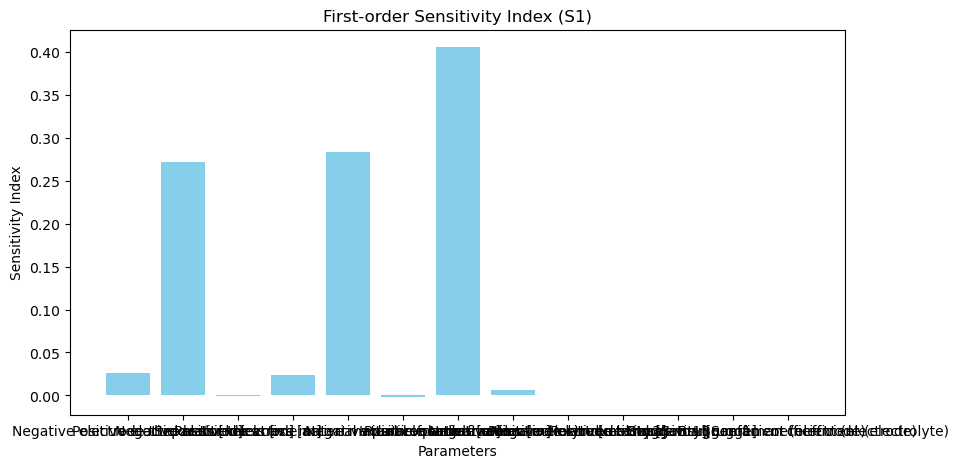

In [10]:
# First-order sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['S1'], color='skyblue')
plt.title('First-order Sensitivity Index (S1)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.show()

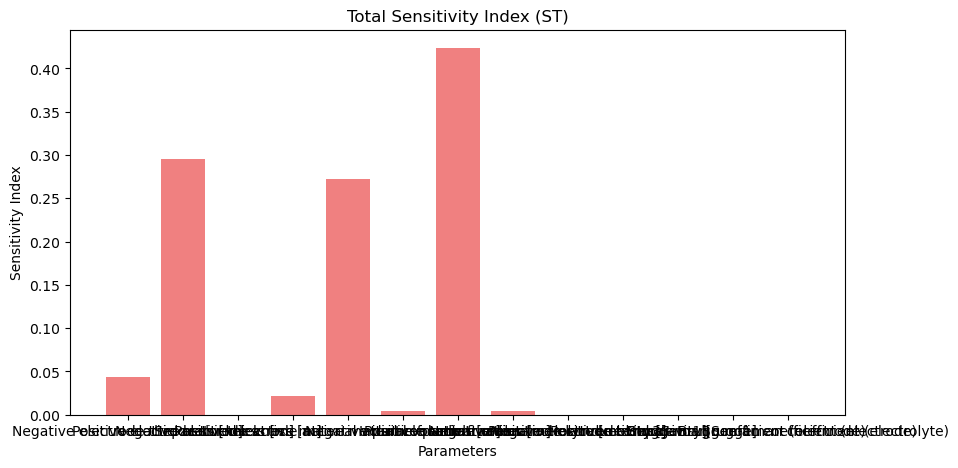

In [11]:
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.show()

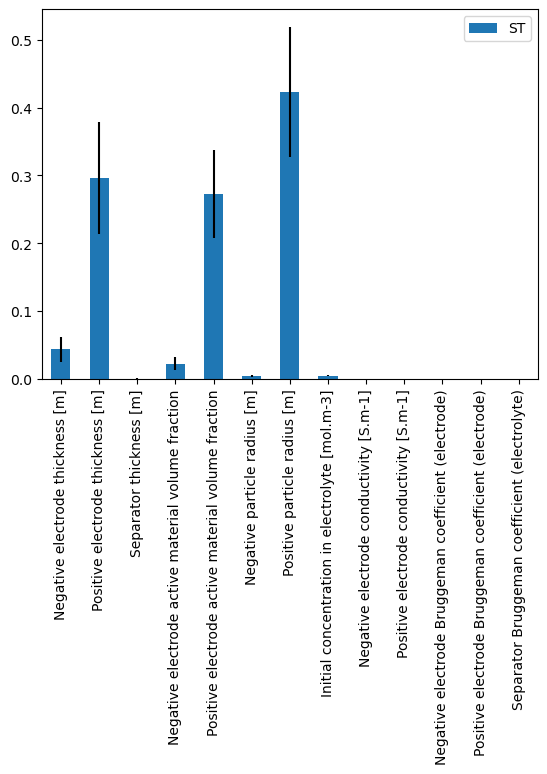

In [12]:
# Second-order sensitivity index(The second-order sensitivity index is a matrix that needs to be shown one by one)
# for i in range(len(params)):
#     for j in range(i+1, len(params)):
#         plt.figure(figsize=(10, 5))
#         plt.bar([f"{params[i]} & {params[j]}"], Si['S2'][i, j], color='lightgreen')
#         plt.title(f'Second-order Sensitivity Index (S2) between {params[i]} and {params[j]}')
#         plt.xlabel('Parameter Pairs')
#         plt.ylabel('Sensitivity Index')
#         plt.show()

Si_df = Si.to_df()
barplot(Si_df[0])
plt.show()